Importo librerie e monto il drive:

In [1]:
import os
import numpy as np
from time import time
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import IPython.display as ipd
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
import tarfile
from shutil import copyfile

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Carico i file:

In [3]:
copyfile("/content/drive/MyDrive/digital signal/consegna_assignments/Copia di recordings.tar", "recordings.tar")
tar=tarfile.open("recordings.tar")
tar.extractall()
tar.close()


In [4]:
# Placecholder for feature extractor
def identity(input):
    return input

# Data loader
def load_data(feature_extractor=identity, normalize=False):

    labels = []
    features = []

    for f in sorted(os.listdir('./recordings')):
        if f.endswith('.wav'):
            # Load file and compute the requested features
            _, signal = wav.read('./recordings/' + f)
            cur_features = feature_extractor(signal)
            #signal scorre gli sound_data dei vari recordings, feature extractor
            #lo sostituirò con un'effettiva estrazione di feature (e non l'identità)
            features.append(cur_features)

            # Classes
            label = f.split('_')[0]
            labels.append(label)

    # X: features, y: labels
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size = 0.1, random_state = 1)

    if normalize:
        eps = 0.001
        X_train = np.array(X_train)
        X_train_mean = X_train.mean(axis=0)
        X_train_std = X_train.std(axis=0)
        X_train = (X_train - X_train_mean + eps)/(X_train_std + eps)
        X_train = [row for row in X_train]

        X_test = [row for row in (np.array(X_test) - X_train_mean + eps)/(X_train_std + eps)]
        #normalizzo anche il test set ma con VAR e E del train (abbiamo visto
        #in FDL che normalizzare propriamente il train è teoricamente sbagliato)

    return X_train, X_test, y_train, y_test

Definisco i **feature extractors** (tra cui zcr):

In [7]:
def energy (input):
  k=0
  for i in input:
    k = k+i*i

  k = k*1.0 #per renderlo un float
  k = np.array(k, ndmin = 1) #per renderlo un array di dim 1 (per compatibilità coi classificatori di scikit-learn)
  return k

#potevo fare anche:
#input = input**2
#return np.sum(input*1.0, keepdims = True)

In [8]:
def duration (input):
  return np.array(input.shape, ndmin = 1)

In [5]:
def zcr (input):
  k=0
  for i in range(0, len(input)-1):
    if input[i]*input[i+1]<0:
      k=k+1

  return np.array(k, ndmin = 1)

In [9]:
def combo(input):
    return np.concatenate((energy(input),duration(input),zcr(input)))

In [10]:
# Data loading
X_train, X_test, y_train, y_test = load_data(feature_extractor = combo, normalize = True)

<ipython-input-7-129f32f03328>:4: RuntimeWarning: overflow encountered in short_scalars
  k = k+i*i


Ottimizzo gli iperparametri e **traino** il modello:

In [11]:
# Parameters to be tested in cross-validation
param_grid = {'C': [100, 500, 1000],
          'gamma': [0.005, 0.01, 0.1, 0.5, 1.0], }

# Support Vector Machine initialization
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid, cv=2)

# Training
t0 = time()
clf = clf.fit(X_train, y_train)
print('Training completed in %0.3fs' % (time() - t0))

Training completed in 4.177s


In [12]:
# Result of the cross validation for parameters selection
print('Best parameters combination:')
print(' C: '+str(clf.best_estimator_.C))
print(' gamma: '+str(clf.best_estimator_.gamma))

Best parameters combination:
 C: 100
 gamma: 0.5


**Performance**:

In [13]:
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.62      0.59      0.61        17
           1       0.29      0.50      0.37        10
           2       0.29      0.33      0.31        15
           3       0.29      0.32      0.30        19
           4       0.00      0.00      0.00        11
           5       0.21      0.29      0.24        14
           6       0.83      0.71      0.77        14
           7       0.50      0.21      0.30        19
           8       0.54      0.41      0.47        17
           9       0.47      0.57      0.52        14

    accuracy                           0.39       150
   macro avg       0.41      0.39      0.39       150
weighted avg       0.42      0.39      0.40       150



Confusion matrix:


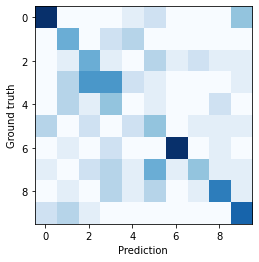

In [16]:
print('Confusion matrix:')
cm = confusion_matrix(y_test, y_pred)
plt.imshow(cm, cmap=plt.cm.Blues);
plt.ylabel('Ground truth');
plt.xlabel('Prediction');